In [ ]:
!pip install transformers sentencepiece
!pip install pickle5

In [ ]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import time
import datetime
import random
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
# Load dataset.
path = "data/df_preprocessed_dataset_012.pkl"
df = pickle.load(open(path, 'rb'))
df

,Project,Issue_Type,Issue,Issue_Type_Verified
0,"""commons-math""",Improvement,math new QRdecomposition codeThis barebones im...,None
1,"""commons-math""",Bug,math SimpleRegression getSumSquaredErrorsgetSu...,"""bug"""
2,"""commons-math""",New Feature,Number Base ConversionI think maths package wi...,None
3,"""commons-math""",Bug,math Function mathfractionProperFractionFormat...,"""bug"""
5,"""commons-math""",Improvement,Adding new methods RealMatrix Copyright The Ap...,None
...,...,...,...,...
156438,"""openwebbeans""",Bug,Ensure initializedappscoped symmetric events s...,None
156444,"""openwebbeans""",Improvement,BaseSeContextsService honor supportsConversati...,None
156445,"""openwebbeans""",Improvement,Request controller thread safeNone,None
156447,"""openwebbeans""",Improvement,Reduce reflection usage default services WebBe...,None


In [ ]:
df['Issue_Type'].value_counts()

Bug            13872
Improvement    12495
New Feature     9522
Name: Issue_Type, dtype: int64

In [ ]:
# One-hot-encode labels.
labels = df.Issue_Type.values
labels = preprocessing.LabelBinarizer().fit(labels)
print(labels.classes_)
labels = labels.transform(df.Issue_Type.values)
df['label'] = labels.tolist()
labels = torch.tensor(labels)
labels

['Bug' 'Improvement' 'New Feature']


tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]])

In [ ]:
# Split dataset and show stats of the split.
X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.10,
                                                  train_size=0.90, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25,
                                                  train_size=0.75, 
                                                  random_state=42, 
                                                  stratify=y_train)

df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_test, 'data_type'] = 'test'
df.loc[X_val, 'data_type'] = 'val'
df['data_type'].value_counts()

train    24225
val       8075
test      3589
Name: data_type, dtype: int64

In [ ]:
# Load BERT tokenizer.
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

# Encode training Cleaned_Data.
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Issue.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)

# Encode validation Cleaned_Data
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Issue.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)

# Encode test Cleaned_Data
encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].Issue.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Extract input ids & attention masks for training, validation, and test from the encodings.
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values.tolist())

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values.tolist())

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values.tolist())

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
batch_size = 16

# Create the DataLoaders for our training, validation and test sets.
train_dataloader = DataLoader(
    dataset_train,                          
    sampler = RandomSampler(dataset_train), 
    batch_size = batch_size                 
    
    )

validation_dataloader = DataLoader(
    dataset_val,                               
    sampler = SequentialSampler(dataset_val),  
    batch_size = batch_size                    
    
    )

test_dataloader = DataLoader(
    dataset_test,                               
    sampler = SequentialSampler(dataset_test),  
    batch_size = batch_size                    
    
    )

In [ ]:
# Modifie the BertForSequenceClassification Class to manage multilabeled dataset.
class AlbertForMultilabelSequenceClassification(AlbertForSequenceClassification):
    def __init__(self, config):
      super().__init__(config)

    def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.albert(input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict)

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions)

In [ ]:
# Load ALBERT model.
model = AlbertForMultilabelSequenceClassification.from_pretrained('albert-base-v2', 
                                                                output_attentions = False, 
                                                                output_hidden_states = False,
                                                                #hidden_dropout_prob = 0.1,
                                                                #attention_probs_dropout_prob = 0.1, 
                                                                num_labels = 3)

model.cuda()

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForMultilabelSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForMultilabelSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classi

AlbertForMultilabelSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_fea

In [ ]:
# Set the optimizer.
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, #5e-5,
                  eps = 1e-8 
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss and timing timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the en.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
  
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode.
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,515.    Elapsed: 0:00:35.
  Batch    80  of  1,515.    Elapsed: 0:01:09.
  Batch   120  of  1,515.    Elapsed: 0:01:43.
  Batch   160  of  1,515.    Elapsed: 0:02:18.
  Batch   200  of  1,515.    Elapsed: 0:02:52.
  Batch   240  of  1,515.    Elapsed: 0:03:26.
  Batch   280  of  1,515.    Elapsed: 0:04:01.
  Batch   320  of  1,515.    Elapsed: 0:04:35.
  Batch   360  of  1,515.    Elapsed: 0:05:09.
  Batch   400  of  1,515.    Elapsed: 0:05:44.
  Batch   440  of  1,515.    Elapsed: 0:06:18.
  Batch   480  of  1,515.    Elapsed: 0:06:53.
  Batch   520  of  1,515.    Elapsed: 0:07:27.
  Batch   560  of  1,515.    Elapsed: 0:08:01.
  Batch   600  of  1,515.    Elapsed: 0:08:36.
  Batch   640  of  1,515.    Elapsed: 0:09:10.
  Batch   680  of  1,515.    Elapsed: 0:09:45.
  Batch   720  of  1,515.    Elapsed: 0:10:19.
  Batch   760  of  1,515.    Elapsed: 0:10:53.
  Batch   800  of  1,515.    Elapsed: 0:11:28.
  Batch   840  of

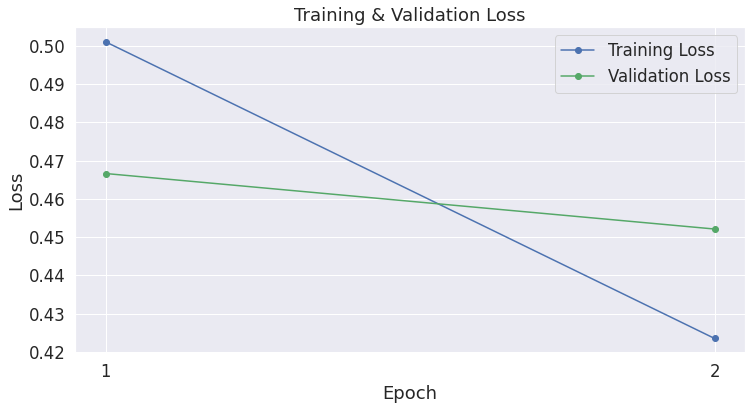

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(1,epochs+1)])

plt.show()

In [ ]:
# Prediction on test set
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, attention_mask=b_input_mask)
                    

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
# Binarize predicted labels.
flat_true_labels = np.concatenate(true_labels, axis=0)
preds = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_predictions = [preds[i] for i in flat_predictions]

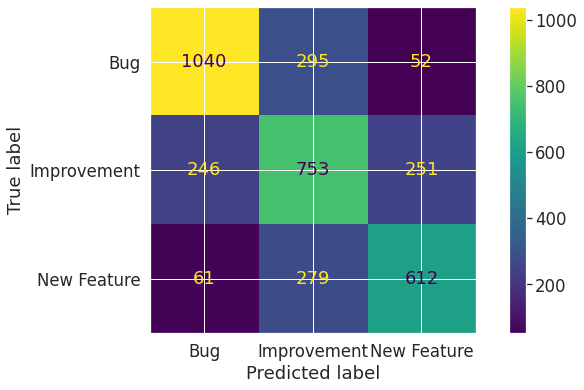

In [ ]:
# Display the confusion matrix.
target_labels = ['Bug', 'Improvement', 'New Feature']
true_lb = [target_labels[i.index(1)] for i in flat_true_labels.tolist()]
true_lb
flat_pred = [target_labels[i.index(1)] for i in flat_predictions]
flat_pred
cm = confusion_matrix(true_lb, flat_pred, labels=['Bug', 'Improvement', 'New Feature'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bug', 'Improvement', 'New Feature'])
disp.plot()
plt.show()

In [ ]:
# Display metrics report.
target_names = ['Bug', 'Improvement', 'New Feature']
print(classification_report(flat_true_labels, flat_predictions, target_names=target_names))

              precision    recall  f1-score   support

         Bug       0.77      0.75      0.76      1387
 Improvement       0.57      0.60      0.58      1250
 New Feature       0.67      0.64      0.66       952

   micro avg       0.67      0.67      0.67      3589
   macro avg       0.67      0.67      0.67      3589
weighted avg       0.67      0.67      0.67      3589
 samples avg       0.67      0.67      0.67      3589



In [ ]:
import os

# Save the model.
output_dir = '/content/model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /content/model_save/


('/content/model_save/tokenizer_config.json',
 '/content/model_save/special_tokens_map.json',
 '/content/model_save/spiece.model',
 '/content/model_save/added_tokens.json')